In [ ]:
# [CLS]トークンを利用

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='011'
    wandb=True
    resume=None  # [None, 'auto', 'always']
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="roberta-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Mon Jun  6 09:05:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 5.3 MB/s 
CPU times: user 1.1 s, sys: 201 ms, total: 1.3 s
Wall time: 25.1 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,  # 'auto'
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 15.5 MB/s 
     |████████████████████████████████| 181 kB 59.9 MB/s 
     |████████████████████████████████| 145 kB 70.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

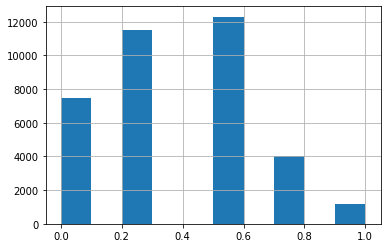

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts_rev = df['text_rev'].values
        self.labels = df['score'].values

        # # 学習はオーギュメンテーション
        # rev_mask = (np.random.rand(len(df))) > 0.5  # 0~1の一様分布が閾値より大きいならmask
        # texts_aug = np.where(rev_mask, self.texts_rev, self.texts)
        # if phase=='train':
        #     self.texts = texts_aug

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 32m 50s) Loss: 0.9265(0.9265) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 34s (remain 24m 49s) Loss: 0.6513(0.6949) Grad: 14893.1543  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 3m 7s (remain 23m 13s) Loss: 0.6850(0.6819) Grad: 23218.9902  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 4m 40s (remain 21m 39s) Loss: 0.5852(0.6815) Grad: 2320.1208  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 6m 14s (remain 20m 6s) Loss: 0.6855(0.6764) Grad: 2127.7549  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 7m 47s (remain 18m 32s) Loss: 0.6617(0.6744) Grad: 784.7250  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 9m 21s (remain 16m 59s) Loss: 0.7072(0.6744) Grad: 3859.6487  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 10m 54s (remain 15m 26s) Loss: 0.5957(0.6721) Grad: 2143.0828  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 12m 27s (remain 13m 52s) Loss: 0.7095(0.6708) Grad: 3739.7004  LR: 0.00001932  
Epoch: [1][900/1693] Elapsed 14m 1s 

Epoch 1 - avg_train_loss: 0.6653  avg_val_loss: 0.6568  time: 1751s
Epoch 1 - Score: 0.0731


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.7862(0.6568) 


Epoch 1 - Save Best Score: 0.0731 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 45m 20s) Loss: 0.6724(0.6724) Grad: inf  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 35s (remain 25m 6s) Loss: 0.6428(0.6605) Grad: 4882.2656  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 3m 8s (remain 23m 22s) Loss: 0.7130(0.6580) Grad: 29685.1055  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 42s (remain 21m 45s) Loss: 0.6192(0.6566) Grad: 10239.4541  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 6m 15s (remain 20m 10s) Loss: 0.7063(0.6555) Grad: 38800.5820  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 7m 49s (remain 18m 36s) Loss: 0.6578(0.6552) Grad: 8657.7100  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 9m 22s (remain 17m 2s) Loss: 0.6403(0.6559) Grad: 11522.5068  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 10m 55s (remain 15m 28s) Loss: 0.6441(0.6567) Grad: 7408.8223  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 12m 29s (remain 13m 54s) Loss: 0.6116(0.6560) Grad: 16758.8555  LR: 0.00001402  
Epoch: [2][900/1693] Elapsed 14m 

Epoch 2 - avg_train_loss: 0.6572  avg_val_loss: 0.6568  time: 1752s
Epoch 2 - Score: 0.1143


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.7677(0.6568) 


Epoch 2 - Save Best Score: 0.1143 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 32m 21s) Loss: 0.5998(0.5998) Grad: inf  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 35s (remain 25m 0s) Loss: 0.6728(0.6587) Grad: 7173.4131  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 3m 8s (remain 23m 20s) Loss: 0.6583(0.6573) Grad: 4467.2495  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 42s (remain 21m 44s) Loss: 0.6308(0.6570) Grad: 18467.6719  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 6m 15s (remain 20m 10s) Loss: 0.6748(0.6565) Grad: 9185.0312  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 7m 49s (remain 18m 35s) Loss: 0.6088(0.6573) Grad: 13558.2881  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 9m 22s (remain 17m 1s) Loss: 0.6314(0.6568) Grad: 12438.2363  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 10m 55s (remain 15m 28s) Loss: 0.7171(0.6561) Grad: 29144.0684  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 12m 29s (remain 13m 54s) Loss: 0.6652(0.6555) Grad: 11018.0869  LR: 0.00000637  
Epoch: [3][900/1693] Elapsed 14m 

Epoch 3 - avg_train_loss: 0.6561  avg_val_loss: 0.6563  time: 1752s
Epoch 3 - Score: 0.3896


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.7828(0.6563) 


Epoch 3 - Save Best Score: 0.3896 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 31m 54s) Loss: 0.6928(0.6928) Grad: inf  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 35s (remain 24m 58s) Loss: 0.6367(0.6511) Grad: 6311.5825  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 3m 8s (remain 23m 19s) Loss: 0.6329(0.6567) Grad: 12379.4551  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 41s (remain 21m 44s) Loss: 0.6032(0.6574) Grad: 25565.2559  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 6m 15s (remain 20m 9s) Loss: 0.6490(0.6554) Grad: 11338.9814  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 7m 48s (remain 18m 35s) Loss: 0.7011(0.6539) Grad: 10228.2314  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 9m 22s (remain 17m 1s) Loss: 0.6696(0.6510) Grad: 15251.3721  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 10m 55s (remain 15m 27s) Loss: 0.5893(0.6491) Grad: 8407.7197  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 12m 29s (remain 13m 54s) Loss: 0.6919(0.6479) Grad: 43663.0234  LR: 0.00000085  
Epoch: [4][900/1693] Elapsed 14m

Epoch 4 - avg_train_loss: 0.6366  avg_val_loss: 0.6221  time: 1753s
Epoch 4 - Score: 0.5105


EVAL: [586/587] Elapsed 2m 49s (remain 0m 0s) Loss: 0.7008(0.6221) 


Epoch 4 - Save Best Score: 0.5105 Model
========== fold: 0 result ==========
Score: 0.5105
========== fold: 1 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1725] Elapsed 0m 1s (remain 38m 23s) Loss: 0.6728(0.6728) Grad: 433065.2500  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 35s (remain 25m 29s) Loss: 0.7093(0.6781) Grad: 15157.8828  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 3m 8s (remain 23m 50s) Loss: 0.6370(0.6654) Grad: 5221.5513  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 41s (remain 22m 13s) Loss: 0.6284(0.6611) Grad: 7269.9248  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 6m 15s (remain 20m 39s) Loss: 0.6619(0.6521) Grad: 25216.4746  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 7m 48s (remain 19m 5s) Loss: 0.6196(0.6471) Grad: 16246.3506  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 9m 22s (remain 17m 31s) Loss: 0.6376(0.6411) Grad: 36285.0938  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 10m 55s (remain 15m 57s) Loss: 0.5589(0.6341) Grad: 21670.1719  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 12m 29s (remain 14m 24s) Loss: 0.7033(0.6287) Grad: 44000.6016  LR: 0.00001934  
Epoch: [1][900/1725] El

Epoch 1 - avg_train_loss: 0.6007  avg_val_loss: 0.5644  time: 1772s
Epoch 1 - Score: 0.7693


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.5039(0.5644) 


Epoch 1 - Save Best Score: 0.7693 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 31m 59s) Loss: 0.6416(0.6416) Grad: inf  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 35s (remain 25m 32s) Loss: 0.5401(0.5503) Grad: 22355.9277  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 3m 8s (remain 23m 50s) Loss: 0.4823(0.5504) Grad: 20942.7793  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 42s (remain 22m 14s) Loss: 0.6572(0.5537) Grad: 24234.3906  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 6m 15s (remain 20m 39s) Loss: 0.5347(0.5511) Grad: 9368.7832  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 7m 48s (remain 19m 5s) Loss: 0.5268(0.5502) Grad: 15322.1992  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 9m 22s (remain 17m 31s) Loss: 0.5024(0.5493) Grad: 23153.0547  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 10m 55s (remain 15m 57s) Loss: 0.5656(0.5500) Grad: 19672.2852  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 12m 29s (remain 14m 24s) Loss: 0.5155(0.5510) Grad: 15549.3867  LR: 0.00001409  
Epoch: [2][900/1725] Elapsed 1

Epoch 2 - avg_train_loss: 0.5488  avg_val_loss: 0.5618  time: 1773s
Epoch 2 - Score: 0.7913


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.4929(0.5618) 


Epoch 2 - Save Best Score: 0.7913 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 35m 58s) Loss: 0.4987(0.4987) Grad: inf  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 35s (remain 25m 35s) Loss: 0.5713(0.5335) Grad: 43809.8633  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 3m 9s (remain 23m 53s) Loss: 0.4180(0.5252) Grad: 67436.8359  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 42s (remain 22m 16s) Loss: 0.5630(0.5272) Grad: 42526.7656  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 6m 16s (remain 20m 41s) Loss: 0.5416(0.5226) Grad: 26620.2676  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 7m 49s (remain 19m 7s) Loss: 0.5548(0.5210) Grad: 44586.1328  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 9m 23s (remain 17m 33s) Loss: 0.5334(0.5209) Grad: 37920.8555  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 10m 56s (remain 15m 59s) Loss: 0.3826(0.5214) Grad: 43167.1250  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 12m 30s (remain 14m 25s) Loss: 0.5199(0.5202) Grad: 29633.1484  LR: 0.00000644  
Epoch: [3][900/1725] Elapsed 

Epoch 3 - avg_train_loss: 0.5220  avg_val_loss: 0.5722  time: 1775s
Epoch 3 - Score: 0.7934


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.4912(0.5722) 


Epoch 3 - Save Best Score: 0.7934 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 39m 1s) Loss: 0.5126(0.5126) Grad: 80692.7109  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 35s (remain 25m 38s) Loss: 0.5113(0.5282) Grad: 159830.7344  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 3m 9s (remain 23m 53s) Loss: 0.5773(0.5205) Grad: 122244.5000  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 42s (remain 22m 17s) Loss: 0.5728(0.5170) Grad: 17641.0078  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 6m 16s (remain 20m 42s) Loss: 0.5107(0.5180) Grad: 25600.7031  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 7m 49s (remain 19m 7s) Loss: 0.5497(0.5177) Grad: 25926.6992  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 9m 23s (remain 17m 33s) Loss: 0.5123(0.5171) Grad: 57867.8750  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 10m 56s (remain 15m 59s) Loss: 0.4717(0.5160) Grad: 16996.9551  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 12m 30s (remain 14m 25s) Loss: 0.5712(0.5155) Grad: 10746.8750  LR: 0.00000088  
Epoch: [4][900/1725] 

Epoch 4 - avg_train_loss: 0.5155  avg_val_loss: 0.5852  time: 1775s
Epoch 4 - Score: 0.7918


EVAL: [553/554] Elapsed 2m 40s (remain 0m 0s) Loss: 0.4899(0.5852) 


========== fold: 1 result ==========
Score: 0.7934
========== fold: 2 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1741] Elapsed 0m 1s (remain 36m 35s) Loss: 0.9181(0.9181) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 35s (remain 25m 44s) Loss: 0.6475(0.6911) Grad: 16015.6826  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 3m 8s (remain 24m 5s) Loss: 0.6443(0.6660) Grad: 20175.9336  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 42s (remain 22m 29s) Loss: 0.5986(0.6529) Grad: 21434.5742  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 6m 15s (remain 20m 55s) Loss: 0.4947(0.6413) Grad: 20069.9062  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 7m 49s (remain 19m 21s) Loss: 0.6363(0.6327) Grad: 9856.1367  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 9m 22s (remain 17m 47s) Loss: 0.6251(0.6238) Grad: 23973.1836  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 10m 56s (remain 16m 13s) Loss: 0.7176(0.6185) Grad: 19777.9375  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 12m 29s (remain 14m 40s) Loss: 0.6843(0.6150) Grad: 21635.1465  LR: 0.00001935  
Epoch: [1][900/1741] Elapsed 1

Epoch 1 - avg_train_loss: 0.5918  avg_val_loss: 0.5717  time: 1784s
Epoch 1 - Score: 0.7670


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.3788(0.5717) 


Epoch 1 - Save Best Score: 0.7670 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 34m 42s) Loss: 0.6143(0.6143) Grad: 138351.9688  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 35s (remain 25m 50s) Loss: 0.5133(0.5534) Grad: 109829.0547  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 3m 8s (remain 24m 7s) Loss: 0.4906(0.5469) Grad: 68376.6641  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 42s (remain 22m 30s) Loss: 0.5817(0.5459) Grad: 186912.5156  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 6m 15s (remain 20m 55s) Loss: 0.5052(0.5437) Grad: 84700.5938  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 7m 49s (remain 19m 21s) Loss: 0.6471(0.5435) Grad: 33769.2148  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 9m 22s (remain 17m 47s) Loss: 0.4956(0.5435) Grad: 39902.5586  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 10m 56s (remain 16m 13s) Loss: 0.5337(0.5438) Grad: 38376.4570  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 12m 29s (remain 14m 39s) Loss: 0.5120(0.5435) Grad: 45258.7500  LR: 0.00001412  
Epoch: [2][900/1741

Epoch 2 - avg_train_loss: 0.5403  avg_val_loss: 0.5679  time: 1785s
Epoch 2 - Score: 0.7955


EVAL: [538/539] Elapsed 2m 35s (remain 0m 0s) Loss: 0.4063(0.5679) 


Epoch 2 - Save Best Score: 0.7955 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 34m 44s) Loss: 0.4061(0.4061) Grad: 145750.5156  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 35s (remain 25m 47s) Loss: 0.5902(0.5076) Grad: 147686.2969  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 3m 8s (remain 24m 7s) Loss: 0.5139(0.5108) Grad: 65836.7500  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 42s (remain 22m 31s) Loss: 0.5898(0.5148) Grad: 57399.3008  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 6m 15s (remain 20m 56s) Loss: 0.4890(0.5164) Grad: 159439.1875  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 7m 49s (remain 19m 21s) Loss: 0.5225(0.5203) Grad: 85724.1328  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 9m 22s (remain 17m 47s) Loss: 0.5626(0.5216) Grad: 42167.0117  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 10m 56s (remain 16m 13s) Loss: 0.6442(0.5245) Grad: 157807.8281  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 12m 29s (remain 14m 40s) Loss: 0.5539(0.5248) Grad: 59321.9375  LR: 0.00000647  
Epoch: [3][900/174

In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()